In [1]:
import dataset
import matplotlib.pyplot as plt
import tree_search
import bounds
import numpy as np
import sympy
sympy.init_printing()

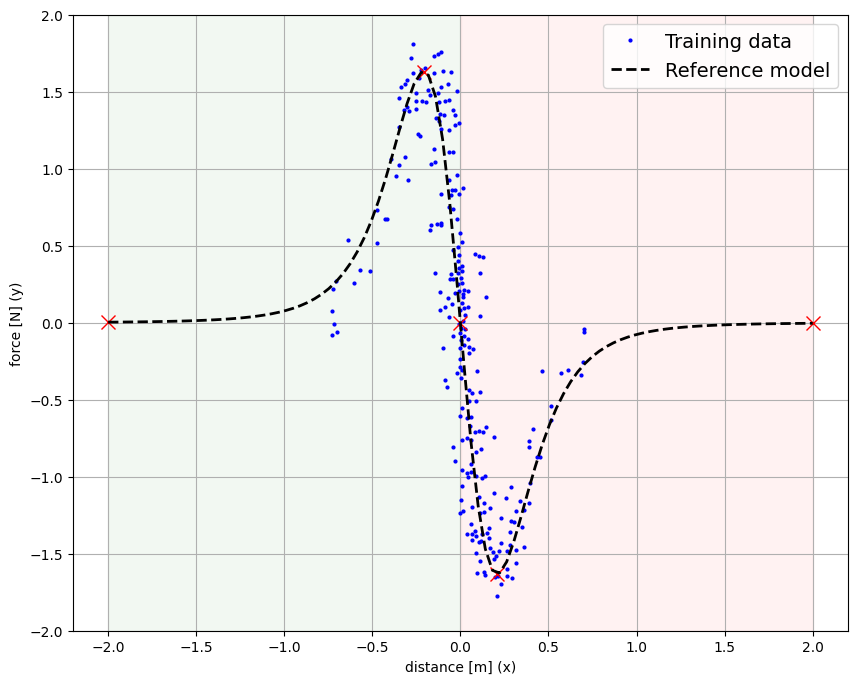

In [2]:
S = dataset.MagmanDatasetScaled()
#S.sample(size=500, noise=0.05, mesh=False)
S.load('data/magman.csv')
#S.erase(0.3, 0.7)
S.split()  # train_size=0.7 by default
S.plot()

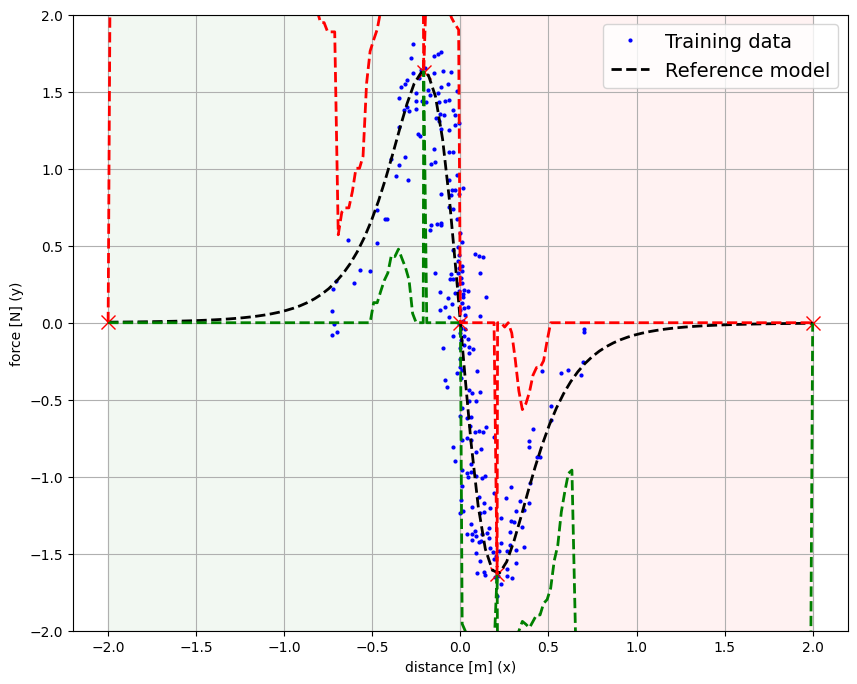

In [3]:
bin_bounds = bounds.compute_bounds(S, 200)
bounds.plot_bounds(S, bin_bounds)

In [4]:
stree, data_tuning_report, knowledge_image_tuning_report, knowledge_deriv_tuning_report = \
    tree_search.infer_syntaxtree(S, bin_bounds=bin_bounds, max_degree=6, max_degree_inner=1, max_depth=10, trials=150, pk_pressure=1.)

if data_tuning_report is not None:
    print(f"\nData Root found:    {data_tuning_report['root_found']}")
    print(f"Data MSE:             {data_tuning_report['mse']}")
    print(f"Data R2:              {1 - (data_tuning_report['sse'] / S.data_sst)}")

if knowledge_image_tuning_report is not None:
    print(f"\nKnowledge (image) Root found: {knowledge_image_tuning_report['root_found']}")
    print(f"Knowledge (image) MSE:        {knowledge_image_tuning_report['mse']}")

if knowledge_deriv_tuning_report is not None:
    print(f"\nKnowledge (deriv) Root found: {knowledge_deriv_tuning_report['root_found']}")
    print(f"Knowledge (deriv) MSE:        {knowledge_deriv_tuning_report['mse']}")

if stree is not None:
    print(f"\nModel: " + stree.tostring())

[0, 0], [0, 406], [406, 406], [406, 406]
Total data constraints:      251
Total knowledge constraints: 406
========== Syntax Tree Inference ==========

Data tuning (avg time):      0 ms
Knowledge tuning (avg time):   0 ms
Data tuning (total time):      2232 ms
Knowledge tuning (total time): 11777 ms

Get system (avg time): 0 ms
Get system (total time): 13597 ms
Get system (total calls): 55477

Setcoeffs (total time): 10 ms

Data Root found:    False
Data MSE:             0.24739099903133818
Data R2:              0.7637867286396492

Knowledge (image) Root found: False
Knowledge (image) MSE:        5.274370128521888e-09

Model: P_a(x)/P_b(x)


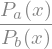

In [5]:
sympy.parse_expr(stree.tostring(), evaluate=False)

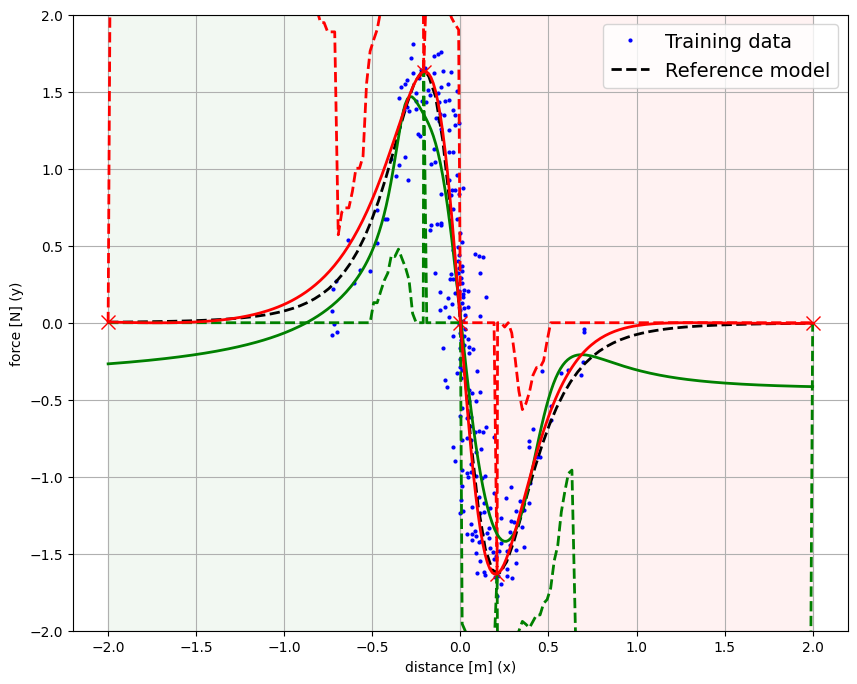

In [6]:
S.plot()
bounds.plot_bounds(S, bin_bounds)

x = np.linspace(S.xl, S.xu, 300)

if data_tuning_report is not None:
    stree.set_coeffs(data_tuning_report['sol'].tolist())
    plt.plot(x, stree.evaluate(x), linestyle='solid', linewidth=2, color='green', label='Data model');

if knowledge_image_tuning_report is not None:
    stree.set_coeffs(knowledge_image_tuning_report['sol'].tolist())
    plt.plot(x, stree.evaluate(x), linestyle='solid', linewidth=2, color='red',   label='Knowledge (image) model');

if knowledge_deriv_tuning_report is not None:
    stree.set_coeffs(knowledge_deriv_tuning_report['sol'].tolist())
    plt.plot(x, stree.evaluate(x), linestyle='solid', linewidth=2, color='orange',   label='Knowledge (deriv) model');

========== Syntax Tree Enhancement ==========
[0, 5], [5, 15], [15, 17], [17, 17]
[Restart #1] MSE improvement from None to 0.018773341231463715
[Restart #2] MSE improvement from 0.018773341231463715 to 6.248181701482001e-32
[Restart #3] MSE improvement from 6.248181701482001e-32 to 6.536094209299992e-33
[Restart #4] No improvement.
[Restart #5] No improvement.
[Restart #6] No improvement.
[Restart #7] No improvement.
[Restart #8] No improvement.
[Restart #9] No improvement.
[Restart #10] MSE improvement from 6.536094209299992e-33 to 3.5606402327460915e-33
Training MSE: 3.5606402327460915e-33


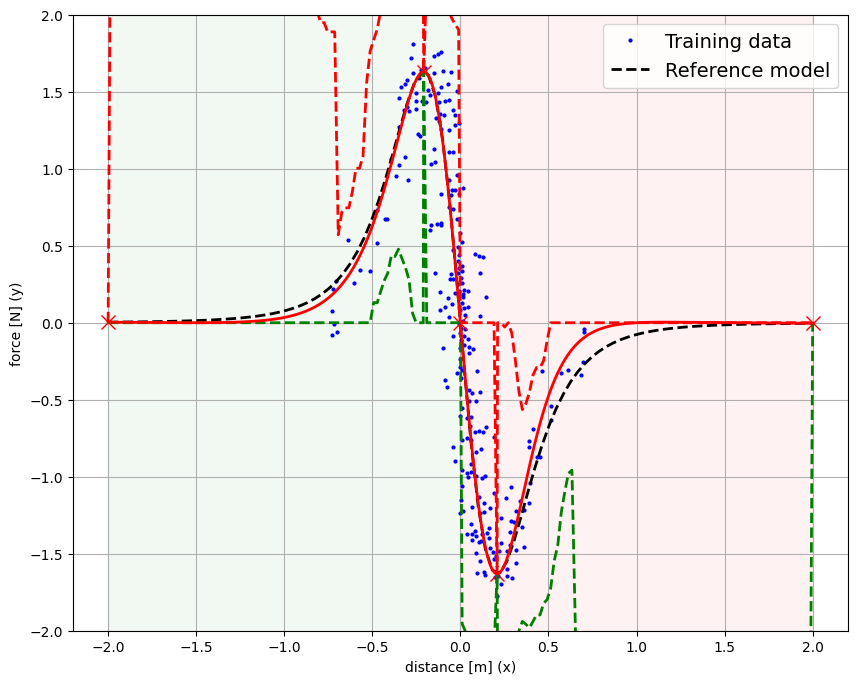

In [7]:
#
# model enhancement
#

sample_size = 5
n_restarts  = 10

bin_bounds = bounds.compute_bounds(S, 200)
#bounds.clean_data(S, bin_bounds)
best_tuning_report = tree_search.enhance_syntax_tree(stree, S, sample_size, bin_bounds=None, n_restarts=n_restarts, data_weight=0, knowledge_weight=1.)


S.plot()
bounds.plot_bounds(S, bin_bounds)
x = np.linspace(S.xl, S.xu, 300)
stree.set_coeffs(best_tuning_report['sol'].tolist())
plt.plot(x, stree.evaluate(x), linestyle='solid', linewidth=2, color='red', label='Final model');

In [8]:
#
# model testing
#

test_mse, test_r2, pk_sat_ration, pk_sat_count, pk_sat_size = tree_search.test_syntax_tree(stree, S, sample_size=1000)
print(f"Test MSE:       {test_mse}")
print(f"Test R2:        {test_r2}")
print(f"PK sat ratio:   {pk_sat_ration}")
print(f"PK sat count:   {pk_sat_count}")
print(f"PK sat size:    {pk_sat_size}")

========== Syntax Tree Testing ==========
Test MSE:       0.3284845071481436
Test R2:        0.6911933316697342
PK sat ratio:   0.8689586447433981
PK sat count:   1744
PK sat size:    2007
